In [81]:
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

import cmocean.cm as cm

%matplotlib inline

# Preliminaries

## Set Region

In [82]:
imin, imax = 160, 350
jmin, jmax = 120, 300

## Bathymetry and Mesh

In [83]:
bathy=nc.Dataset(
    '../ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
#    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
nemolon=bathy.variables['nav_lon'][400:,:]
nemolat=bathy.variables['nav_lat'][400:,:]
bathy=bathy.variables['Bathymetry'][400:,:]
crop = nc.Dataset(
       '../crop.nc')
#    '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
# full mesh
#    '/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc')
#   '../mesh_mask_anha4_201509.nc')
print (crop.variables['tmask'][:].shape)

tmask = crop.variables['tmask'][0,:,400:,:]
umask = crop.variables['umask'][0,:,400:,:]
vmask = crop.variables['vmask'][0,:,400:,:]
gdept = crop.variables['gdept'][0, :, 400:, :]
gdept0 = crop.variables['gdept_0'][0, :]
gdepw0 = crop.variables['gdepw_0'][0, :]
e2t = crop.variables['e2t'][0, 400:, :]
e1t = crop.variables['e1t'][0, 400:, :]
e3t = crop.variables['e3t'][0, :, 400:, :]
e2u = crop.variables['e2u'][0, 400:, :]
e1u = crop.variables['e1u'][0, 400:, :]
e2v = crop.variables['e2v'][0, 400:, :]
e1v = crop.variables['e1v'][0, 400:, :]
e3t0 = crop.variables['e3t_0'][0, :]
mbathy = crop.variables['mbathy'][0, 400:, :]

(1, 50, 800, 544)


In [84]:
deepmask = np.zeros_like(mbathy)
deepmask[mbathy < 44] = 1

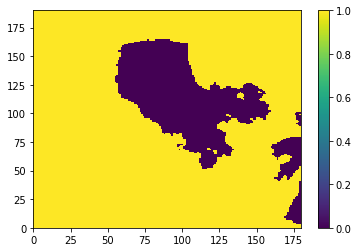

In [85]:
plt.pcolormesh(deepmask[imin:imax, jmin:jmax])
plt.colorbar();

### Calculate e3v and e3u

In [86]:
e3v = np.zeros_like(e3t)
e3u = np.zeros_like(e3t)
for layer in range(50):
    for i in range(imin-5, imax+5):
        for j in range(jmin-5, jmax+5):
            e3v[layer, i, j] = min(e3t[layer, i, j], e3t[layer, i+1, j])
            e3u[layer, i, j] = min(e3t[layer, i, j], e3t[layer, i, j+1])

## Set Boundary Line(s)

In [87]:
pos = 6
if pos == 1:
    ddi = 100
    ddj = 120
    ddj2 = 150
elif pos == 2:
    ddi = 100
    ddj = 125
    ddj2 = 155
elif pos == 3:
    ddi = 100
    ddj = 115
    ddj2 = 145
elif pos == 4:
    ddi = 105
    ddj = 120
    ddj2 = 150
elif pos == 5:
    ddi = 95
    ddj = 120
    ddj2 = 150
elif pos == 6:
    ddi = 110
    ddj = 110
    ddj2 = 129
elif pos == 7:
    ddi = 110
    ddj = 80
    ddj2 = 129
corn1_i = imin
corn1_j = jmin
corn2_i = imin
corn2_j = jmin + ddj
corn3_i = imin + ddi
corn3_j = jmin + ddj
corn4_i = imin + ddi
corn4_j = jmin + ddj2
corn5_i = imax
corn5_j = jmin + ddj2
corn6_i = imax
corn6_j = jmin
#line1_imin, line1_imax = imin, imin+ddi+1
#line1_jmin, line1_jmax = jmin+ddj, jmin+ddj
#line2_imin, line2_imax = imin+ddi, imin+ddi
#line2_jmin, line2_jmax = jmin+ddj, jmin+ddj2+1
#line3_imin, line3_imax = imin+ddi, imax
#line3_jmin, line3_jmax = jmin+ddj2, jmin+ddj2

## Calculate Area and Volume

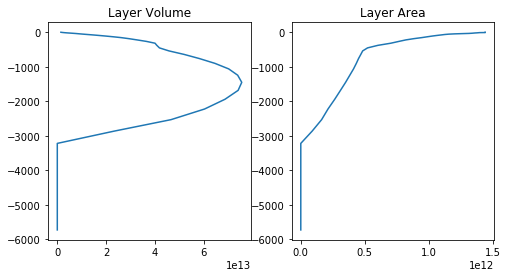

In [88]:
layer_volume = np.zeros_like(gdept0)
layer_area = np.zeros_like(gdept0)
for layer in range(50):
    layer_volume[layer] = (np.sum(e1t[corn1_i:corn3_i, corn1_j:corn3_j] * 
                                 e2t[corn1_i:corn3_i, corn1_j:corn3_j] * 
                                 e3t[layer, corn1_i:corn3_i, corn1_j:corn3_j] * 
                                 tmask[layer, corn1_i:corn3_i, corn1_j:corn3_j] *
                                 deepmask[corn1_i:corn3_i, corn1_j:corn3_j]) +
                           np.sum(e1t[corn4_i:corn5_i, corn6_j:corn5_j] * 
                                 e2t[corn4_i:corn5_i, corn6_j:corn5_j] * 
                                 e3t[layer, corn4_i:corn5_i, corn6_j:corn5_j] * 
                                 tmask[layer, corn4_i:corn5_i, corn6_j:corn5_j] *
                                 deepmask[corn4_i:corn5_i, corn6_j:corn5_j]))
    layer_area[layer] = (np.sum(e1t[corn1_i:corn3_i, corn1_j:corn3_j] * 
                                 e2t[corn1_i:corn3_i, corn1_j:corn3_j] * 
                                 tmask[layer, corn1_i:corn3_i, corn1_j:corn3_j] *
                               deepmask[corn1_i:corn3_i, corn1_j:corn3_j]) +
                           np.sum(e1t[corn4_i:corn5_i, corn6_j:corn5_j] * 
                                 e2t[corn4_i:corn5_i, corn6_j:corn5_j] * 
                                 tmask[layer, corn4_i:corn5_i, corn6_j:corn5_j] *
                                 deepmask[corn4_i:corn5_i, corn6_j:corn5_j]))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(layer_volume, -gdept0)
axs[1].plot(layer_area, -gdept0)
axs[0].set_title('Layer Volume')
axs[1].set_title('Layer Area');

## Look at the position and Bathymetry along the boundary line(s)

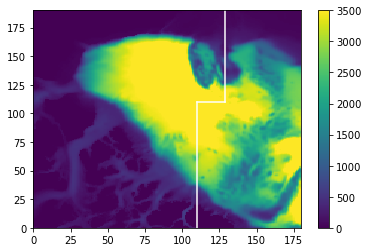

In [89]:
plt.pcolormesh(bathy[imin:imax, jmin:jmax], vmax=3500, vmin=0)
plt.colorbar()
plt.plot(np.array([corn2_j, corn3_j]) - jmin, np.array([corn2_i, corn3_i]) - imin, 'w')
plt.plot(np.array([corn3_j, corn4_j]) - jmin, np.array([corn3_i, corn4_i]) - imin, 'w')
plt.plot(np.array([corn4_j, corn5_j]) - jmin, np.array([corn4_i, corn5_i]) - imin, 'w');

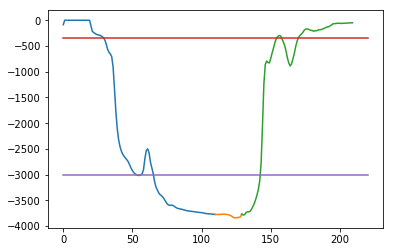

In [90]:
plt.plot(np.arange(corn3_i - corn2_i + 1),-bathy[corn2_i:corn3_i+1, corn2_j])
plt.plot(np.arange(corn4_j - corn3_j + 1) + (corn3_i - corn2_i), -bathy[corn3_i, corn3_j:corn4_j+1])
plt.plot(np.arange(corn5_i - corn4_i + 1) + (corn3_i - corn2_i) + (corn4_j - corn3_j),
         - bathy[corn4_i:corn5_i+1, corn4_j])
plt.plot([0, 220], [-350, -350])
plt.plot([0, 220], [-3000, -3000]);

# Base Functions

In [91]:
def vel(keyword, T, ENG='EXH005'):
    """'design to obtain velocity field
    T: year, value: eg. 2002
    'ENG': string, can be ENG3,EXH001 or EXH005
    """
    # addstr='/ocean/xiaoxiny/research/result_jasper/data_eng3/'
    addstr = '../'
    if keyword =='U':
        nc_filename=sorted(glob.glob('%s/*%s*U*%s.nc'%(addstr,ENG,T)))
        uvel=nc.Dataset(nc_filename[0])
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    elif keyword =='V':
        nc_filename=sorted(glob.glob('%s/*%s*V*%s.nc'%(addstr,ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('%s/*%s*W*%s.nc'%(addstr,ENG,T)))
        wvel=nc.Dataset(nc_filename[0])
        data =wvel.variables['vovecrtz'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

## Look at Velocity along the Boundary for a Given Year

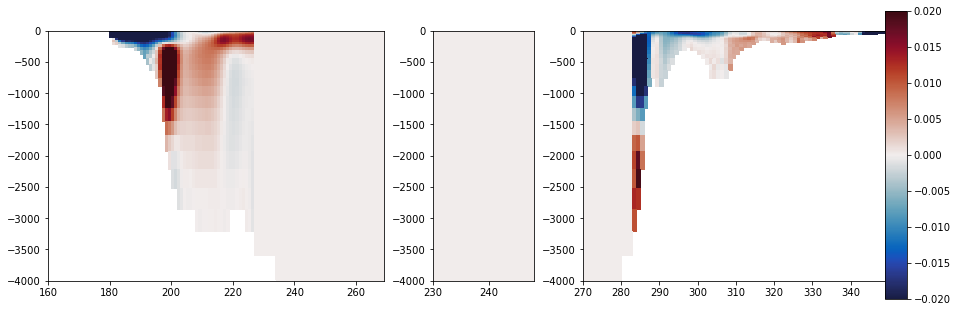

In [92]:
year = 2014
u_vel = vel('U', year)
v_vel = vel('V', year)

fig, axs = plt.subplots(1, 3, figsize=(15, 4.6),gridspec_kw = {'width_ratios':[100, 30, 90]})
mesh = axs[0].pcolormesh(np.arange(corn2_i, corn3_i), -gdept0[:], 
                     u_vel[:, corn2_i:corn3_i, corn2_j]
                         * deepmask[corn2_i:corn3_i, corn2_j], cmap=cm.balance, vmax=0.02, vmin=-0.02)
axs[1].pcolormesh(np.arange(corn3_j, corn4_j), -gdept0[:], 
                     -v_vel[:, corn3_i, corn3_j:corn4_j]
                  * deepmask[corn3_i, corn3_j:corn4_j], cmap=cm.balance, vmax=0.02, vmin=-0.02)
axs[2].pcolormesh(np.arange(corn4_i, corn5_i), -gdept0[:], 
                     u_vel[:, corn4_i:corn5_i, corn4_j]
                  * deepmask[corn4_i:corn5_i, corn4_j], cmap=cm.balance, vmax=0.02, vmin=-0.02)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.07, 0.02, 0.87])
fig.colorbar(mesh, cax=cbar_ax)
for ax in axs:
    ax.set_ylim(-4000, 0)

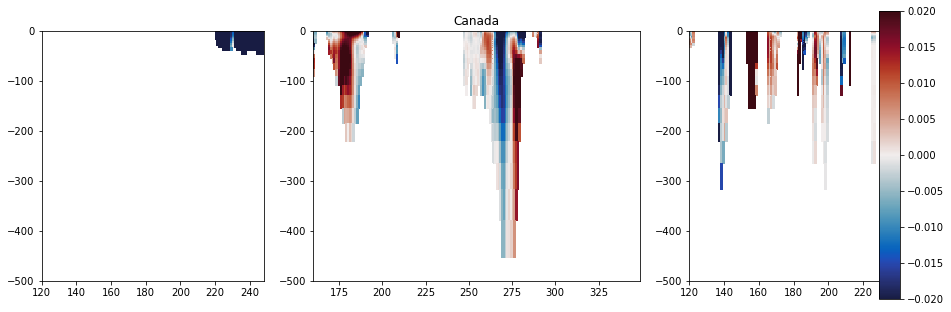

In [93]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4.6),gridspec_kw = 
                        {'width_ratios':[corn5_j-corn6_j, corn6_i-corn1_i, corn2_j-corn1_j]})
mesh = axs[0].pcolormesh(np.arange(corn6_j, corn5_j), -gdept0[:], 
                     v_vel[:, corn5_i, corn6_j:corn5_j], cmap=cm.balance, vmax=0.02, vmin=-0.02)
axs[1].pcolormesh(np.arange(corn1_i, corn6_i), -gdept0[:], 
                     -u_vel[:, corn1_i:corn6_i, corn1_j], cmap=cm.balance, vmax=0.02, vmin=-0.02)
axs[1].set_title('Canada')
axs[2].pcolormesh(np.arange(corn1_j, corn2_j), -gdept0[:], 
                     -v_vel[:, corn1_i, corn1_j:corn2_j], cmap=cm.balance, vmax=0.02, vmin=-0.02)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.07, 0.02, 0.87])
fig.colorbar(mesh, cax=cbar_ax);
for ax in axs:
    ax.set_ylim(-500, 0);

## Look at Total Volume Flux

In [94]:
oneyear = 86400*365

### With Cindy's small bottom cells removed mesh

159 120 corn 1 across
160 119 corn 1 up
corn 1 match
159 230 corn 2 across
160 230 corn 2 up
corn 2 match
270 230 corn 3 up
270 231 corn 3 across
corn 3 match
270 249 corn 4 across
271 249 corn 4 up
corn4 match
350 249 corn5 up
350 249 corn5 across
corn5 match
350 120 corn 6 across
350 119 corn 6 up
corn6 match
-0.178155504728 Sv
-3.89551772216


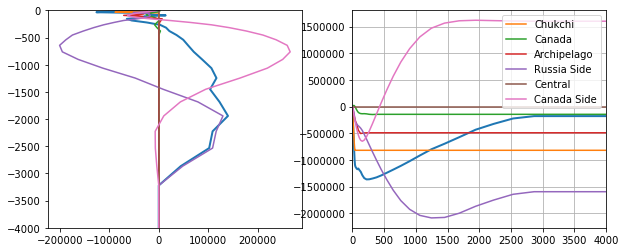

In [95]:
vfluxout_sec1 = np.zeros_like(gdept0)
vfluxout_sec2 = np.zeros_like(gdept0)
vfluxout_sec3 = np.zeros_like(gdept0)
vfluxout_ilow = np.zeros_like(gdept0)
vfluxout_jlow = np.zeros_like(gdept0)
vfluxout_ihi = np.zeros_like(gdept0)
vfluxout = np.zeros_like(gdept0)
print (corn1_i-1, corn1_j, 'corn 1 across')
print (corn1_i, corn1_j-1, 'corn 1 up')
print ('corn 1 match')
print (corn1_i-1, corn2_j, 'corn 2 across')
print (corn2_i, corn2_j, 'corn 2 up')
print ('corn 2 match')
print (corn3_i, corn2_j, 'corn 3 up')
print (corn3_i, corn3_j+1, 'corn 3 across')
print ('corn 3 match')
print (corn3_i, corn4_j, 'corn 4 across')
print (corn4_i+1, corn4_j, 'corn 4 up')
print ('corn4 match')
print (corn5_i, corn4_j, 'corn5 up')
print (corn5_i, corn5_j, 'corn5 across')
print ('corn5 match')
print (corn5_i, corn6_j, 'corn 6 across')
print (corn6_i, corn1_j-1, 'corn 6 up')
print ('corn6 match')
for layer in range(50):
    vfluxout_ilow[layer] = np.sum(v_vel[layer, corn1_i-1, corn1_j:corn2_j+1].filled()
                          * e1v[corn1_i-1, corn1_j:corn2_j+1]
                                  * deepmask[corn1_i-1, corn1_j:corn2_j+1]
                          * e3v[layer, corn1_i-1, corn1_j:corn2_j+1])
    
    vfluxout_sec1[layer] = np.sum(u_vel[layer, corn2_i:corn3_i+1, corn2_j].filled()
                           * e2u[corn2_i:corn3_i+1, corn2_j] 
                                  * deepmask[corn2_i:corn3_i+1, corn2_j] 
                           * e3u[layer, corn2_i:corn3_i+1, corn2_j])
    
    vfluxout_sec2[layer] =  np.sum(v_vel[layer, corn3_i, corn3_j+1:corn4_j+1].filled() 
                          * e1v[corn3_i, corn3_j+1:corn4_j+1] 
                                   * deepmask[corn3_i, corn3_j+1:corn4_j+1] 
                          * e3v[layer, corn3_i, corn3_j+1:corn4_j+1])
    
    vfluxout_sec3[layer] = np.sum(u_vel[layer, corn4_i+1:corn5_i+1, corn4_j].filled() 
                        * e2u[corn4_i+1:corn5_i+1, corn4_j]
                                  * deepmask[corn4_i+1:corn5_i+1, corn4_j]
                                  * e3u[layer,corn4_i+1:corn5_i+1, corn4_j])
    
    vfluxout_ihi[layer] = np.sum(v_vel[layer, corn5_i, corn6_j:corn5_j+1].filled()
                          * e1v[corn5_i, corn6_j:corn5_j+1]
                                 * deepmask[corn5_i, corn6_j:corn5_j+1]
                                 * e3v[layer,corn5_i, corn6_j:corn5_j+1])
    
    vfluxout_jlow[layer] = np.sum(u_vel[layer, corn1_i:corn6_i+1, corn1_j-1].filled()
                          * e2u[corn1_i:corn6_i+1, corn1_j-1] 
                                  * deepmask[corn1_i:corn6_i+1, corn1_j-1] 
                                  * e3u[layer,corn1_i:corn6_i+1, corn1_j-1])
    
    vfluxout[layer] = (vfluxout_sec1[layer] - vfluxout_sec2[layer] + vfluxout_sec3[layer]
                       - vfluxout_ilow[layer] - vfluxout_jlow[layer] + vfluxout_ihi[layer])
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(vfluxout, -gdept0, linewidth=2)
axs[0].plot(vfluxout_ihi, -gdept0)
axs[0].plot(vfluxout_jlow, -gdept0)
axs[0].plot(vfluxout_ilow, -gdept0)
axs[0].plot(vfluxout_sec3, -gdept0)
axs[0].plot(vfluxout_sec2, -gdept0)
axs[0].plot(vfluxout_sec1, -gdept0)
axs[0].set_ylim((-4000, 0))

axs[1].plot(gdept0, np.cumsum(vfluxout), linewidth=2)
axs[1].plot(gdept0, np.cumsum(vfluxout_ihi), label='Chukchi')
axs[1].plot(gdept0, np.cumsum(vfluxout_jlow), label='Canada')
axs[1].plot(gdept0, np.cumsum(vfluxout_ilow), label='Archipelago')
axs[1].plot(gdept0, np.cumsum(vfluxout_sec3), label='Russia Side')
axs[1].plot(gdept0, np.cumsum(vfluxout_sec2), label='Central')
axs[1].plot(gdept0, np.cumsum(vfluxout_sec1), label='Canada Side')
axs[1].set_xlim((0, 4000))
axs[1].legend()
axs[1].grid()
print (np.cumsum(vfluxout)[49]/1e6, 'Sv')
print (np.cumsum(vfluxout)[49]/layer_area[0]*oneyear)

# Th

In [157]:
def get_vertical_advection(yearin):
    tr8, tr10, tr12, tt = get_tracer(yearin)
    w_vel = vel('W', yearin)
    vt_advection = np.zeros_like(tt)
    for i in range(49):
        tt_onwgrid = 0.5*(tt[i] + tt[i+1])
        vt_advection[i+1] = w_vel[i+1] * tt_onwgrid * e1t * e2t
    layer_vertical_advection = (
        (vt_advection[:, corn1_i:corn3_i, corn1_j:corn3_j] 
         * deepmask[corn1_i:corn3_i, corn1_j:corn3_j]).sum(axis=1).sum(axis=1) +
        (vt_advection[:, corn4_i:corn5_i, corn6_j:corn5_j]
         * deepmask[corn4_i:corn5_i, corn6_j:corn5_j]).sum(axis=1).sum(axis=1))
    return layer_vertical_advection

In [97]:
def get_tracer(yearin):
    nt = yearin - 1991 
    tracerfile = nc.Dataset('../EXH005-btscav_v2_19912016.nc')
    tr8 = tracerfile.variables['TR_8'][nt, :]
    tr10 = tracerfile.variables['TR_10'][nt, :]
    tr12 = tracerfile.variables['TR_12'][nt, :]
    tt = tr8+tr10
    year = (tracerfile.variables['time_counter'][nt]/(86400*365) + 1991 -0.5).astype(int)
    if (year != yearin):
        print ('problems!!')
    return tr8, tr10, tr12, tt

## Th Advection (with Boundary)

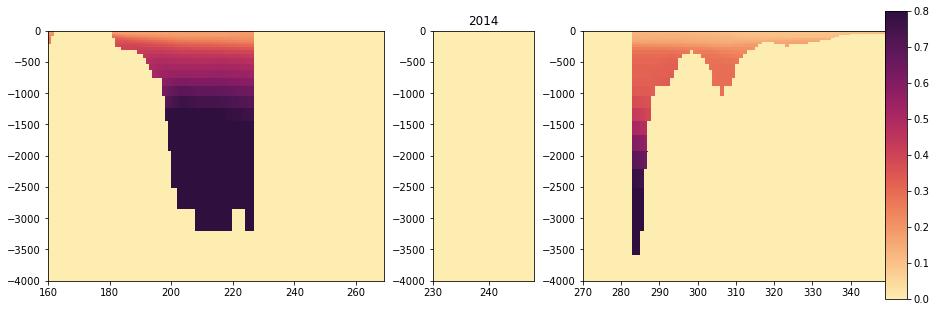

In [98]:
yearin = 2003
tr8, tr10, tr12, tt = get_tracer(yearin)
fig, axs = plt.subplots(1, 3, figsize=(15, 4.6),gridspec_kw = {'width_ratios':[100, 30, 90]})
mesh = axs[0].pcolormesh(np.arange(corn2_i, corn3_i), -gdept0[:], 
                     tt[:, corn2_i:corn3_i, corn2_j] *
                         deepmask[corn2_i:corn3_i, corn2_j], cmap=cm.matter, vmax=0.8, vmin=-0.0)
axs[1].pcolormesh(np.arange(corn3_j, corn4_j), -gdept0[:], 
                     tt[:, corn3_i, corn3_j:corn4_j] *
                  deepmask[corn3_i, corn3_j:corn4_j], cmap=cm.matter, vmax=0.8, vmin=-0.0)
axs[1].set_title(year)
axs[2].pcolormesh(np.arange(corn4_i, corn5_i), -gdept0[:], 
                     tt[:, corn4_i:corn5_i, corn4_j] *
                  deepmask[corn4_i:corn5_i, corn4_j], cmap=cm.matter, vmax=0.8, vmin=-0.0)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.07, 0.02, 0.87])
fig.colorbar(mesh, cax=cbar_ax)
for ax in axs:
    ax.set_ylim(-4000, 0)

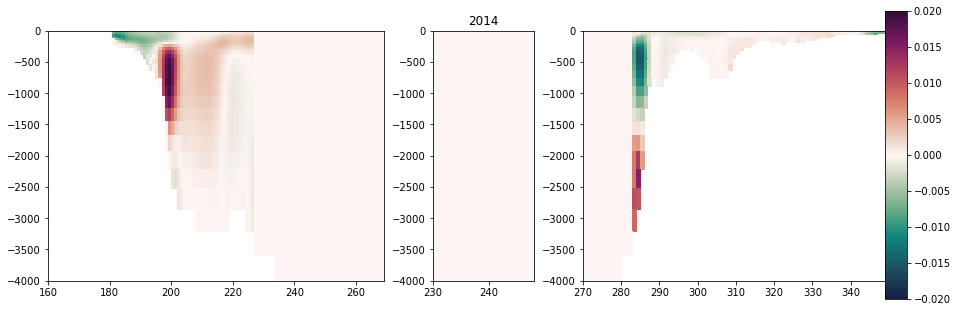

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4.6),gridspec_kw = {'width_ratios':[100, 30, 90]})
mesh = axs[0].pcolormesh(np.arange(corn2_i, corn3_i), -gdept0[:], 
                     tt[:, corn2_i:corn3_i, corn2_j] * u_vel[:, corn2_i:corn3_i, corn2_j]
                         * deepmask[corn2_i:corn3_i, corn2_j]
                         , cmap=cm.curl, vmax=0.02, vmin=-0.02)
axs[1].pcolormesh(np.arange(corn3_j, corn4_j), -gdept0[:], 
                     -tt[:, corn3_i, corn3_j:corn4_j] * v_vel[:, corn3_i, corn3_j:corn4_j]
                  * deepmask[corn3_i, corn3_j:corn4_j], 
                  cmap=cm.curl, vmax=0.02, vmin=-0.02)
axs[1].set_title(year)
axs[2].pcolormesh(np.arange(corn4_i, corn5_i), -gdept0[:], 
                     tt[:, corn4_i:corn5_i, corn4_j] * u_vel[:, corn4_i:corn5_i, corn4_j]
                  * deepmask[corn4_i:corn5_i, corn4_j], 
                  cmap=cm.curl, vmax=0.02, vmin=-0.02)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.07, 0.02, 0.87])
fig.colorbar(mesh, cax=cbar_ax)
for ax in axs:
    ax.set_ylim(-4000, 0)

In [100]:
def advection(tt, u_vel, v_vel):
    fluxout_sec1 = np.zeros_like(gdept0)
    fluxout_sec2 = np.zeros_like(gdept0)
    fluxout_sec3 = np.zeros_like(gdept0)
    fluxout_ilow = np.zeros_like(gdept0)
    fluxout_jlow = np.zeros_like(gdept0)
    fluxout_ihi = np.zeros_like(gdept0)
    fluxout = np.zeros_like(gdept0)
    for layer in range(50):
        fluxout_ilow[layer] = np.sum(v_vel[layer, corn1_i-1, corn1_j:corn2_j+1].filled()
                          * e1v[corn1_i-1, corn1_j:corn2_j+1]
                                     * deepmask[corn1_i-1, corn1_j:corn2_j+1]
                          * e3v[layer, corn1_i-1, corn1_j:corn2_j+1] * 0.5 *
                          (tt[layer, corn1_i-1, corn1_j:corn2_j+1] +
                          tt[layer, corn1_i, corn1_j:corn2_j+1]) )
    
        fluxout_sec1[layer] = np.sum(u_vel[layer, corn2_i:corn3_i+1, corn2_j].filled()
                           * e2u[corn2_i:corn3_i+1, corn2_j]
                                     * deepmask[corn2_i:corn3_i+1, corn2_j]
                           * e3u[layer, corn2_i:corn3_i+1, corn2_j] * 0.5 *
                                (tt[layer, corn2_i:corn3_i+1, corn2_j] +
                                tt[layer, corn2_i:corn3_i+1, corn2_j+1]))
    
        fluxout_sec2[layer] =  np.sum(v_vel[layer, corn3_i, corn3_j+1:corn4_j+1].filled() 
                          * e1v[corn3_i, corn3_j+1:corn4_j+1]
                                      * deepmask[corn3_i, corn3_j+1:corn4_j+1]
                          * e3v[layer, corn3_i, corn3_j+1:corn4_j+1] * 0.5 *
                                 (tt[layer, corn3_i, corn3_j+1:corn4_j+1] +
                                 tt[layer, corn3_i+1, corn3_j+1:corn4_j+1]) )
    
        fluxout_sec3[layer] = np.sum(u_vel[layer, corn4_i+1:corn5_i+1, corn4_j].filled() 
                        * e2u[corn4_i+1:corn5_i+1, corn4_j]
                                     * deepmask[corn4_i+1:corn5_i+1, corn4_j]
                                     * e3u[layer,corn4_i+1:corn5_i+1, corn4_j] * 0.5 *
                                (tt[layer,corn4_i+1:corn5_i+1, corn4_j] +
                                tt[layer,corn4_i+1:corn5_i+1, corn4_j+1]))
    
        fluxout_ihi[layer] = np.sum(v_vel[layer, corn5_i, corn6_j:corn5_j+1].filled()
                          * e1v[corn5_i, corn6_j:corn5_j+1]
                                    * e3v[layer, corn5_i, corn6_j:corn5_j+1]
                                   * deepmask[corn5_i, corn6_j:corn5_j+1] * 0.5 *
                               (tt[layer,corn5_i, corn6_j:corn5_j+1] + 
                               tt[layer,corn5_i+1, corn6_j:corn5_j+1]))
    
        fluxout_jlow[layer] = np.sum(u_vel[layer, corn1_i:corn6_i+1, corn1_j-1].filled()
                          * e2u[corn1_i:corn6_i+1, corn1_j-1] 
                                     * deepmask[corn1_i:corn6_i+1, corn1_j-1] 
                                     * e3u[layer,corn1_i:corn6_i+1, corn1_j-1] * 0.5 *
                                (tt[layer,corn1_i:corn6_i+1, corn1_j-1] +
                                tt[layer,corn1_i:corn6_i+1, corn1_j]))
    
        fluxout[layer] = (fluxout_sec1[layer] - fluxout_sec2[layer] + fluxout_sec3[layer]
                       - fluxout_ilow[layer] - fluxout_jlow[layer] + fluxout_ihi[layer])
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(fluxout, -gdept0, linewidth=2)
    axs[0].plot(fluxout_ihi, -gdept0)
    axs[0].plot(fluxout_jlow, -gdept0)
    axs[0].plot(fluxout_ilow, -gdept0)
    axs[0].plot(fluxout_sec3, -gdept0)
    axs[0].plot(fluxout_sec2, -gdept0)
    axs[0].plot(fluxout_sec1, -gdept0)
    axs[0].set_ylim((-4000, 0))

    axs[1].plot(gdept0, np.cumsum(fluxout), linewidth=2)
    axs[1].plot(gdept0, np.cumsum(fluxout_ihi), label='Chukchi')
    axs[1].plot(gdept0, np.cumsum(fluxout_jlow), label='Canada')
    axs[1].plot(gdept0, np.cumsum(fluxout_ilow), label='Archipelago')
    axs[1].plot(gdept0, np.cumsum(fluxout_sec3), label='Russia Side')
    axs[1].plot(gdept0, np.cumsum(fluxout_sec2), label='Central')
    axs[1].plot(gdept0, np.cumsum(fluxout_sec1), label='Canada Side')
    axs[1].set_xlim((0, 4000))
    axs[1].legend()
    axs[1].grid()
    print (np.sum(fluxout)/1e6, 'Sv')
    print (np.sum(fluxout)/np.sum(layer_volume)*oneyear)
    return fluxout

0.962351257733 Sv
0.0269654245542


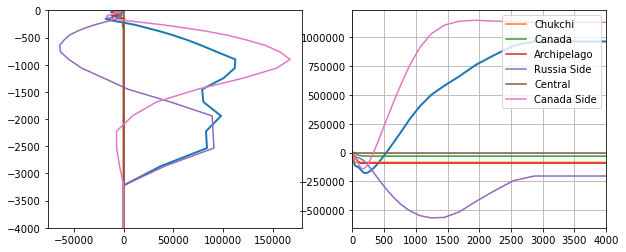

In [101]:
fluxout = advection(tt, u_vel, v_vel)

## Radioactive Source

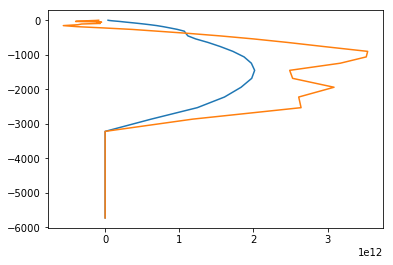

In [102]:
Q = 0.0267
radio_source = Q*layer_volume
plt.plot(radio_source, -gdept0)
plt.plot(fluxout*oneyear, -gdept0)

## Change over a Year

In [103]:
tracerfile = nc.Dataset('../EXH005-btscav_v2_19912016.nc')
nt = yearin-1 - 1991
tr8_2002 = tracerfile.variables['TR_8'][nt, :]
tr10_2002 = tracerfile.variables['TR_10'][nt, :]
tt_2002 = tr8_2002+tr10_2002
nt = yearin+1 - 1991
tr8_2004 = tracerfile.variables['TR_8'][nt, :]
tr10_2004 = tracerfile.variables['TR_10'][nt, :]
tt_2004 = tr8_2004+tr10_2004

In [104]:
def tracer_volume(tt):
    tracer_layer_volume = np.zeros_like(gdept0)
    for layer in range(50):
        tracer_layer_volume[layer] = (np.sum(e1t[corn1_i:corn3_i, corn1_j:corn3_j] * 
                                 e2t[corn1_i:corn3_i, corn1_j:corn3_j] *
                                             deepmask[corn1_i:corn3_i, corn1_j:corn3_j] *
                                 e3t[layer, corn1_i:corn3_i, corn1_j:corn3_j] * 
                                 tt[layer, corn1_i:corn3_i, corn1_j:corn3_j] *           
                                 tmask[layer, corn1_i:corn3_i, corn1_j:corn3_j]) +
                           np.sum(e1t[corn4_i:corn5_i, corn6_j:corn5_j] * 
                                 e2t[corn4_i:corn5_i, corn6_j:corn5_j] *
                                  deepmask[corn4_i:corn5_i, corn6_j:corn5_j] *
                                 e3t[layer, corn4_i:corn5_i, corn6_j:corn5_j] * 
                                 tt[layer, corn4_i:corn5_i, corn6_j:corn5_j] *
                                 tmask[layer, corn4_i:corn5_i, corn6_j:corn5_j]))
    return tracer_layer_volume    

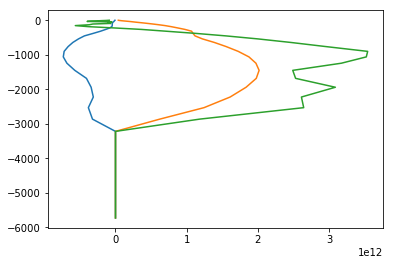

In [105]:
t2002_volume = tracer_volume(tt_2002)
t2004_volume = tracer_volume(tt_2004)

plt.plot((t2004_volume-t2002_volume)/2., -gdept0)
plt.plot(radio_source, -gdept0)
plt.plot(fluxout*oneyear, -gdept0);

In [106]:
layer = 30
yearin = 2002
nt = yearin-1 - 1991
tr8_2002 = tracerfile.variables['TR_8'][nt, :]
tr10_2002 = tracerfile.variables['TR_10'][nt, :]
tt_2002 = tr8_2002+tr10_2002
tv = tracer_volume(tt_2002)
print (tv[layer]/layer_volume[layer])
yearin = 2015
nt = yearin-1 - 1991
tr8_2002 = tracerfile.variables['TR_8'][nt, :]
tr10_2002 = tracerfile.variables['TR_10'][nt, :]
tt_2002 = tr8_2002+tr10_2002
tv = tracer_volume(tt_2002)
print (tv[layer]/layer_volume[layer])
print (layer_volume[layer])

0.31885874662
0.151497359081
4.18233961374e+13


## Sinking

In [107]:
def find_fac(yearin):
    nt = yearin - 1991
    with nc.Dataset('../data_factor0.nc') as fac0:
        fac0 = fac0.variables['factor0'][0,:,400:,:]
    iceinput = tracerfile.variables['TR_12'][nt] 
    Ice_from_predifinelastlayer = np.zeros_like(iceinput[nt,:,:])
    for depth in range (len(fac0[:,0,0])):
        print (">>> reaching 50%") if (depth == len(fac0[:,0,0])/2) else None
        for i in range (len(fac0[0,:,0])):
            for j in range (len(fac0[0,0,:])):
                if fac0[depth,i,j]==1:
                    Ice_from_predifinelastlayer[i,j]=iceinput[depth,i,j]
    with nc.Dataset('../data_factor.nc') as data:
        fac = data.variables['factor'][0, :, 400:, :]
    return fac, Ice_from_predifinelastlayer

In [108]:
fac0file = nc.Dataset('../data_factor0.nc')
fac0 = fac0file.variables['factor0'][0,:,400:,:]
boundary_layer = np.zeros_like(fac0)
for i in range (len(fac0[0,:,0])):
    for j in range (len(fac0[0,0,:])):
        for depth in range (len(fac0[:,0,0])):
            if fac0[depth, i, j] == 1:
                boundary_layer[depth+1:, i, j] = tmask[depth+1:, i, j]

>>> reaching 50%


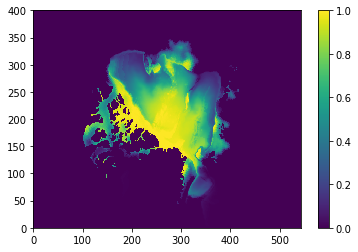

In [109]:
fac, Ice_from_predifinelastlayer = find_fac(2015)
plt.pcolormesh(Ice_from_predifinelastlayer)
plt.colorbar();

In [110]:
def callsinking(layer, ice0, Ice_from_predifinelastlayer, fac):
    "s0 = normal sinking; also consider enhanced sinking if within the enhanced layer - delta_s = enhanced sinking"
#    c0, c1 = -1387, 1874
    c0, c1 = -986.96, 1456.45
    s0 = (c0*np.array(ice0) + c1) * tmask[layer]
    s_from_predifinelastlayer = c0*np.array(Ice_from_predifinelastlayer) + c1
    se = np.zeros_like(s0)
    s  = np.zeros_like(s0)

    for i in range (len(ice0[:,0])):
        for j in range (len(ice0[0,:])):
            se[i, j] = min((3*(1-Ice_from_predifinelastlayer[i, j])+1)*s_from_predifinelastlayer[i, j], c1) 
    s = s0 + (se - s0) * fac
#    print (se[line1_imin+40, line1_jmin])
#    print (s[line1_imin+40, line1_jmin])
    return s

In [111]:
sinkit = np.empty_like(tmask)
#s0 = np.empty_like(tmask)
#se = np.empty_like(tmask)
for layer in range(15):
    sinkit[layer] = callsinking(layer, np.ones_like(tmask[layer]), np.ones_like(tmask[layer]), fac[layer])

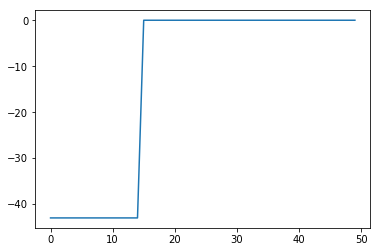

In [112]:
plt.plot(sinkit[:, corn3_i, corn3_j])

In [113]:
def load_tracers(layer, nt):    
        TR_10_upperlayer = tracerfile.variables['TR_10'][nt, layer-1]
        TR_10_currentlayer = tracerfile.variables['TR_10'][nt, layer]
          
        TR_12_upperlayer = tracerfile.variables['TR_12'][nt, layer-1] 
        TR_12_currentlayer = tracerfile.variables['TR_12'][nt, layer]     
        
        return (TR_10_upperlayer, TR_10_currentlayer, 
               TR_12_upperlayer, TR_12_currentlayer)

In [114]:
def find_deltasink(yearin, Ice_from_predifinelastlayer, fac):
    nt = yearin - 1991
    deltasink = np.zeros((50, 400, 544))
    sink_currentlayer = np.zeros_like(deltasink)
    TR_12_currentlayer = np.zeros_like(deltasink)
    for layer in range(50):
        TR_10_upperlayer, TR_10_currentlayer, TR_12_upperlayer, TR_12_currentlayer[layer] = load_tracers(layer, nt)
        sink_upperlayer = callsinking(layer, TR_12_upperlayer,
                                  Ice_from_predifinelastlayer=Ice_from_predifinelastlayer,fac=fac[layer-1,...] )
        sink_currentlayer[layer] = callsinking(layer, TR_12_currentlayer[layer],
                                    Ice_from_predifinelastlayer=Ice_from_predifinelastlayer,fac=fac[layer,...] )
     
        deltasink[layer] = (sink_upperlayer*TR_10_upperlayer - sink_currentlayer[layer]*TR_10_currentlayer)
#    trb(:,:,jk-1,jpmyt4)*s_th(:,:,jk-1)-trb(:,:,jk,jpmyt4)*s_th(:,:,jk))*rdz(:,:,jk+1)
    return deltasink

In [115]:
def find_sink(yearin, Ice_from_predifinelastlayer, fac):
    nt = yearin - 1991
    deltasink = np.zeros((50, 400, 544))
    sink_currentlayer = np.zeros_like(deltasink)
    TR_12_currentlayer = np.zeros_like(deltasink)
    for layer in range(50):
        TR_10_upperlayer, TR_10_currentlayer, TR_12_upperlayer, TR_12_currentlayer[layer] = load_tracers(layer, nt)
        sink_currentlayer[layer] = callsinking(layer, TR_12_currentlayer[layer],
                                    Ice_from_predifinelastlayer=Ice_from_predifinelastlayer,fac=fac[layer,...] )     
    return sink_currentlayer

In [116]:
def sum_deltasink(deltasink):
    layer_delta_sink = np.zeros_like(gdept0)
    for layer in range(50):
        layer_delta_sink[layer] = (np.sum(e1t[corn1_i:corn3_i, corn1_j:corn3_j] * 
                                 e2t[corn1_i:corn3_i, corn1_j:corn3_j] *
                                          deepmask[corn1_i:corn3_i, corn1_j:corn3_j] *
                                 deltasink[layer, corn1_i:corn3_i, corn1_j:corn3_j] *           
                                 tmask[layer, corn1_i:corn3_i, corn1_j:corn3_j]) +
                               np.sum(e1t[corn4_i:corn5_i, corn6_j:corn5_j] * 
                                 e2t[corn4_i:corn5_i, corn6_j:corn5_j] * 
                                      deepmask[corn4_i:corn5_i, corn6_j:corn5_j] *
                                 deltasink[layer, corn4_i:corn5_i, corn6_j:corn5_j] *
                                 tmask[layer, corn4_i:corn5_i, corn6_j:corn5_j]))
    return layer_delta_sink

In [117]:
#deltasink = find_deltasink(yearin, Ice_from_predifinelastlayer, fac)
sinks = find_sink(yearin, Ice_from_predifinelastlayer, fac)

In [118]:
deltasink = find_deltasink(yearin, Ice_from_predifinelastlayer, fac)
layer_delta_sink = sum_deltasink(deltasink)

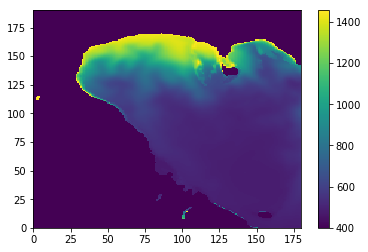

In [119]:
plt.pcolormesh(sinks[31, imin:imax, jmin:jmax], vmin=400)
plt.colorbar()

2015 23


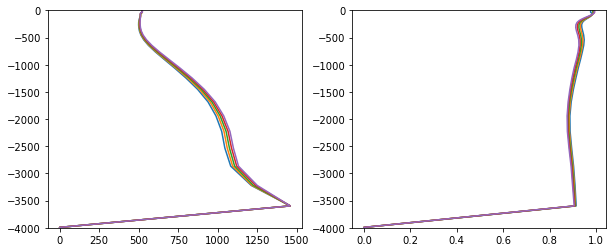

In [120]:
print (yearin, nt)
TR_12_currentlayer = np.zeros_like(sinks)
for layer in range(50):
    (TR_10_upperlayer, TR_10_currentlayer, 
               TR_12_upperlayer, TR_12_currentlayer[layer]) = load_tracers(layer, nt)   
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
#plt.plot(sinks[:, corn3_i-5:corn3_i+5, corn3_j], -gdept0)
ax[0].plot(sinks[:, corn4_i:corn4_i+5, corn4_j], -gdept0)
#ax[0].plot(sinks[:, corn4_i:corn4_i+5, corn4_j]*tmask[:, corn4_i:corn4_i+5, corn4_j], -gdept0)
#ax[0].plot(tmask[:, corn4_i, corn4_j], -gdept0, 'o')
ax[0].set_ylim(-4000, 0)
#ax[1].plot(TR_12_currentlayer[:, corn4_i:corn4_i+5, corn4_j], -gdept0);
ax[1].plot(tr12[:, corn4_i:corn4_i+5, corn4_j], -gdept0);
ax[1].set_ylim(-4000, 0);

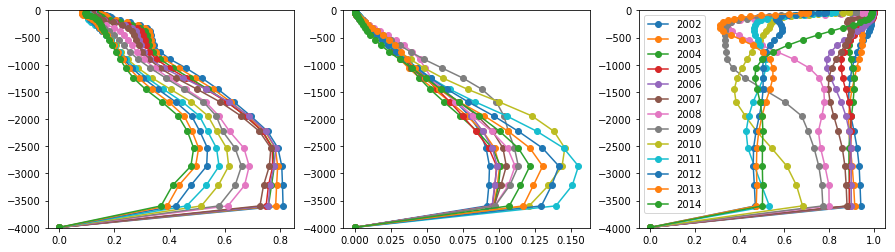

In [121]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for year in range(2002, 2015):
    tr8, tr10, tr12, tt = get_tracer(year)    
    ax[0].plot(tr8[:, corn4_i, corn4_j], -gdept0, 'o-')
    ax[1].plot(tr10[:, corn4_i, corn4_j], -gdept0, 'o-');
    ax[2].plot(tr12[:, corn4_i, corn4_j], -gdept0, 'o-', label=year);
for axi in ax:
    axi.set_ylim(-4000, 0)
ax[2].legend(loc='upper left')

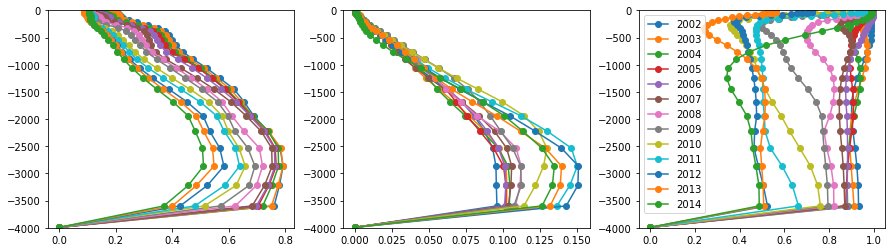

In [122]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for year in range(2002, 2015):
    tr8, tr10, tr12, tt = get_tracer(year)    
    ax[0].plot(tr8[:, corn3_i, corn3_j], -gdept0, 'o-')
    ax[1].plot(tr10[:, corn3_i, corn3_j], -gdept0, 'o-');
    ax[2].plot(tr12[:, corn3_i, corn3_j], -gdept0, 'o-', label=year);
for axi in ax:
    axi.set_ylim(-4000, 0)
ax[2].legend(loc='upper left')

## In Basin Advection

In [123]:
def intra_flux(u_vel, v_vel, tt):
    # in x
    xflux = np.zeros_like(gdept0)
    yflux = np.zeros_like(gdept0)
    myu = u_vel.filled()
    myv = v_vel.filled()
    for i in range(corn1_i, corn3_i+1):
        for j in range(corn1_j, corn2_j):
            if deepmask[i, j] and not deepmask[i, j+1]:
                plt.plot(j, i, 'ko')
                for layer in range(50):
                    xflux[layer] += (myu[layer, i, j]
                          * e2u[i, j] * e3u[layer, i, j] * 0.5 *
                                (tt[layer, i, j] +
                                tt[layer, i, j+1]))
            elif not deepmask[i, j] and deepmask[i, j+1]:
                plt.plot(j, i, 'kx')
                for layer in range(50):
                    xflux[layer] -= (myu[layer, i, j]
                          * e2u[i, j] * e3u[layer, i, j] * 0.5 *
                                (tt[layer, i, j] +
                                tt[layer, i, j+1]))
    for i in range(corn3_i, corn5_i+1):
        for j in range(corn1_j, corn5_j):
            if deepmask[i, j] and not deepmask[i, j+1]:
                plt.plot(j, i, 'mo')
                for layer in range(50):
                    xflux[layer] += (myu[layer, i, j]
                          * e2u[i, j] * e3u[layer, i, j] * 0.5 *
                                (tt[layer, i, j] +
                                tt[layer, i, j+1]))
            elif not deepmask[i, j] and deepmask[i, j+1]:
                plt.plot(j, i, 'mx')
                for layer in range(50):
                    xflux[layer] -= (myu[layer, i, j]
                          * e2u[i, j] * e3u[layer, i, j] * 0.5 *
                                (tt[layer, i, j] +
                                tt[layer, i, j+1]))
# in y       
    for i in range(corn1_i, corn3_i):
        for j in range(corn1_j, corn2_j):
            if deepmask[i, j] and not deepmask[i+1, j]:
                plt.plot(j, i, 'bo')
                for layer in range(50):
                    yflux[layer] += (myv[layer, i, j]
                          * e1v[i, j] * e3v[layer, i, j] * 0.5 *
                                (tt[layer, i, j] +
                                tt[layer, i+1, j]))
            elif not deepmask[i, j] and deepmask[i+1, j]:
                plt.plot(j, i, 'bx')
                for layer in range(50):
                    yflux[layer] -= (myv[layer, i, j]
                          * e1v[i, j] * e3v[layer, i, j] * 0.5 *
                                (tt[layer, i, j] +
                                tt[layer, i+1, j]))
    for i in range(corn3_i, corn5_i):
        for j in range(corn1_j, corn5_j):
            if deepmask[i, j] and not deepmask[i+1, j]:
                plt.plot(j, i, 'co')
                for layer in range(50):
                    yflux[layer] += (myv[layer, i, j]
                          * e1v[i, j] * e3v[layer, i, j] * 0.5 *
                                (tt[layer, i, j] +
                                tt[layer, i+1, j]))
            elif not deepmask[i, j] and deepmask[i+1, j]:
                plt.plot(j, i, 'cx')
                for layer in range(50):
                    yflux[layer] -= (myv[layer, i, j]
                          * e1v[i, j] * e3v[layer, i, j] * 0.5 *
                                (tt[layer, i, j] +
                                tt[layer, i+1, j]))
    return xflux, yflux

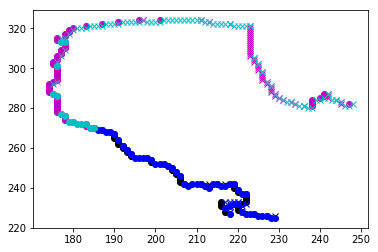

In [124]:
xflux, yflux = intra_flux(u_vel, v_vel, tt)

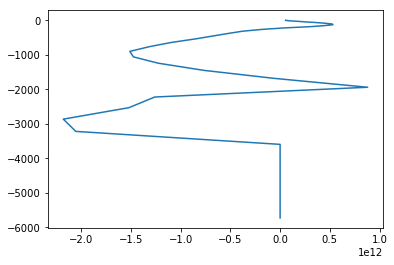

In [125]:
plt.plot((xflux+yflux)*oneyear, -gdept0)

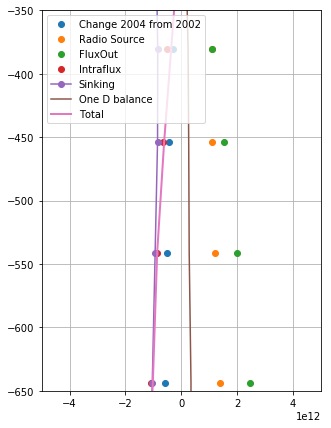

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(5, 7))
ax.plot((t2004_volume-t2002_volume)/2., -gdept0, 'o', label='Change 2004 from 2002')
ax.plot(radio_source, -gdept0, 'o', label='Radio Source')
ax.plot(fluxout*oneyear, -gdept0, 'o', label='FluxOut')
ax.plot((xflux+yflux)*oneyear, -gdept0, 'o', label='Intraflux')
ax.plot(layer_delta_sink, -gdept0, 'o-', label='Sinking')
ax.plot(radio_source+layer_delta_sink, -gdept0, label='One D balance')
ax.plot(radio_source + layer_delta_sink - fluxout*oneyear -(xflux+yflux)*oneyear, -gdept0, label="Total", linewidth=2)
ax.set_ylim(-650, -350)
#ax.set_ylim(-4000, 0)
ax.set_xlim(-0.5e13, 0.5e13)
ax.legend()
ax.grid()

# Put it All Together

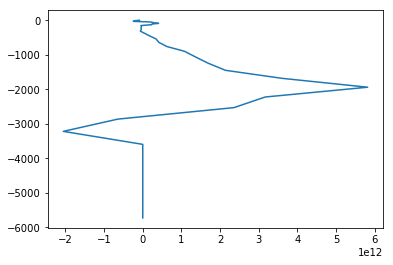

In [127]:
# for 2003
unaccounted = (t2004_volume-t2002_volume)/2. - (radio_source + layer_delta_sink - 
                                                (xflux+yflux+fluxout)*oneyear)
plt.plot(unaccounted[1:], -gdept0[1:])
#plt.ylim(-650, -350)

0.0175972617457 Sv
0.000493081533537
>>> reaching 50%
0.558638768236 Sv
0.0156532569962
>>> reaching 50%
1.04703872648 Sv
0.0293383975522
>>> reaching 50%
0.635401411835 Sv
0.0178041735747
>>> reaching 50%
0.403880306267 Sv
0.0113168698436
>>> reaching 50%
0.234603901894 Sv
0.00657368478072
>>> reaching 50%
0.548755447873 Sv
0.0153763228441
>>> reaching 50%


/Users/sallen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.456868528546 Sv
0.01280161868
>>> reaching 50%
0.653134994417 Sv
0.0183010748665
>>> reaching 50%
0.689470196023 Sv
0.0193192001401
>>> reaching 50%
0.633558162791 Sv
0.0177525250808
>>> reaching 50%
0.439414341194 Sv
0.0123125461419
>>> reaching 50%


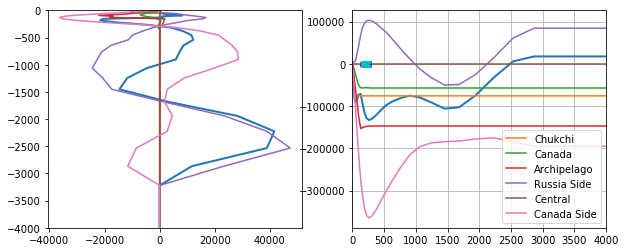

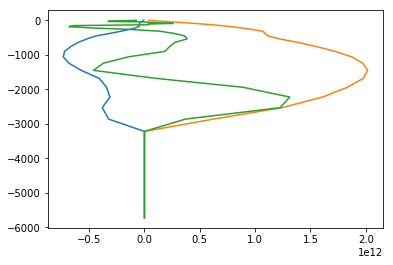

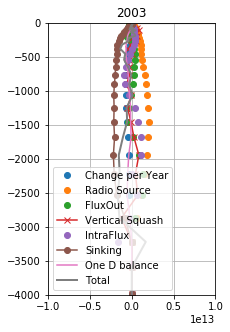

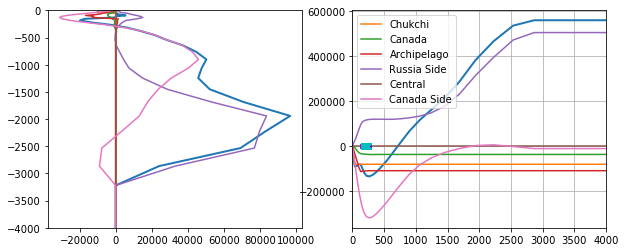

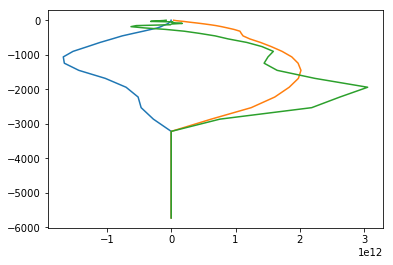

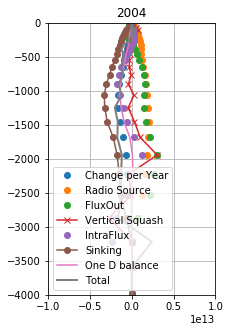

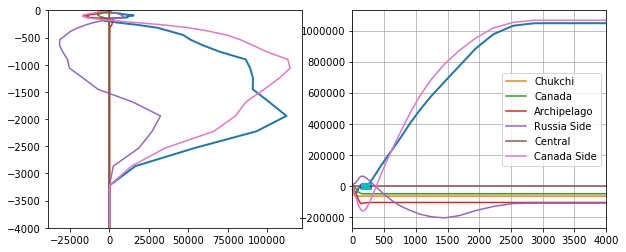

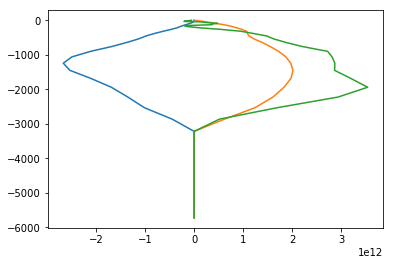

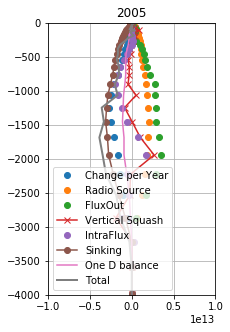

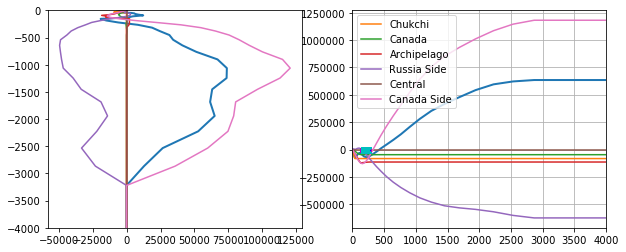

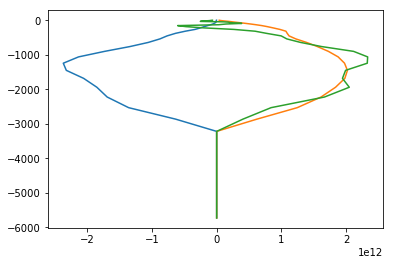

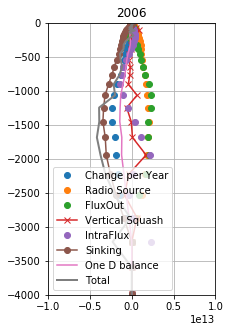

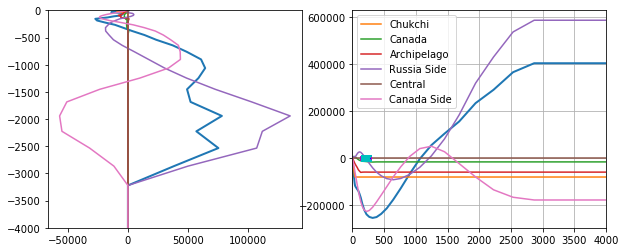

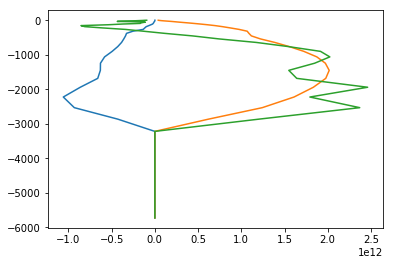

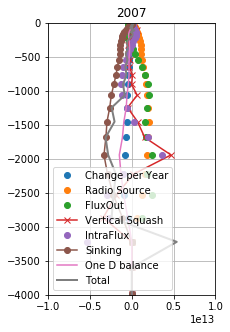

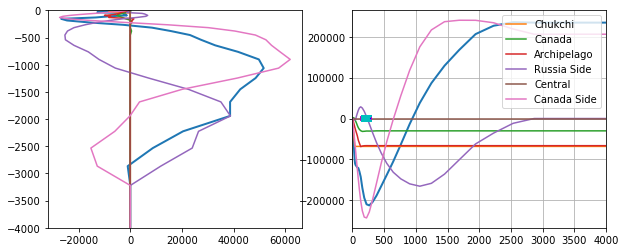

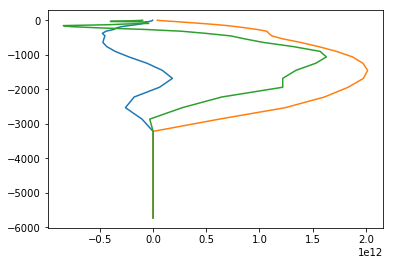

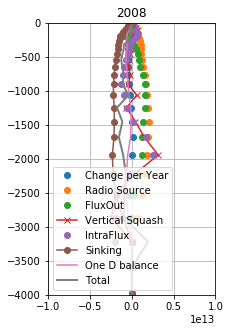

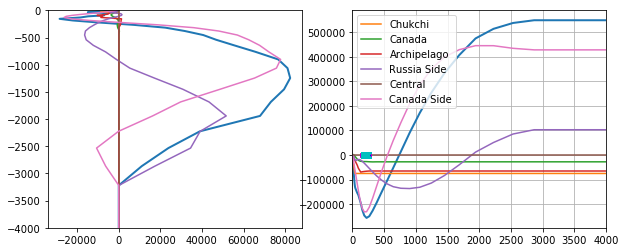

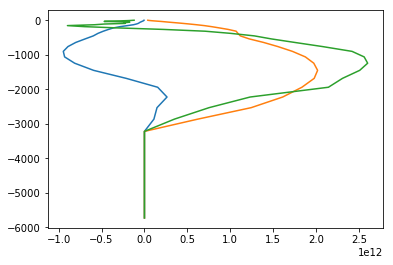

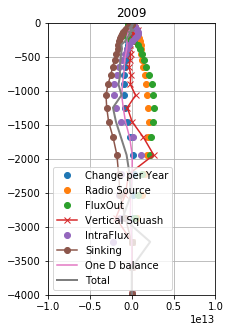

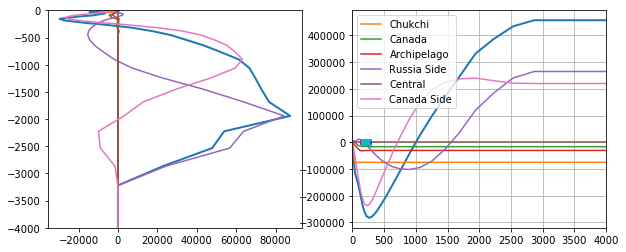

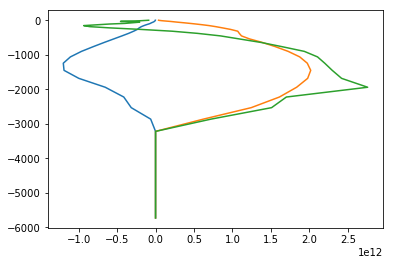

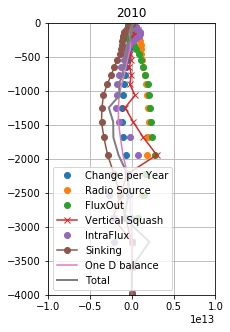

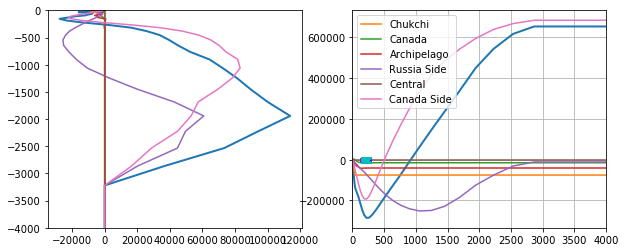

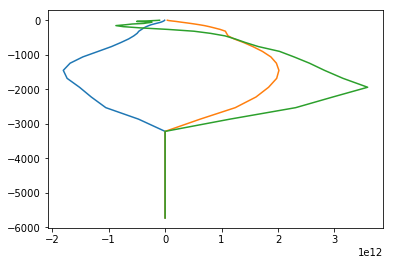

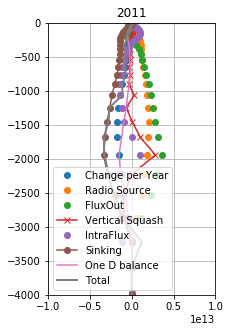

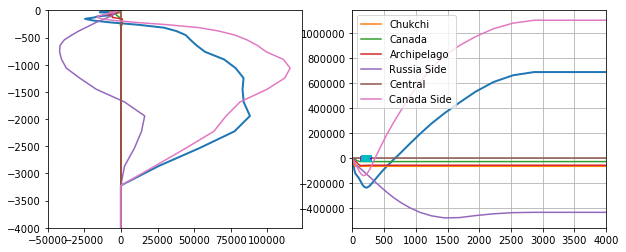

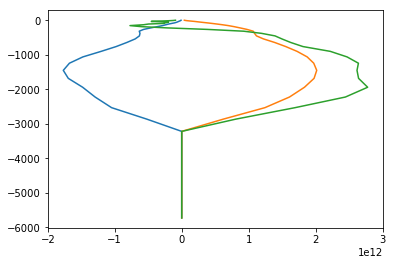

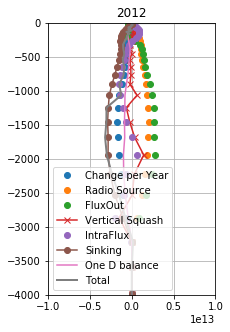

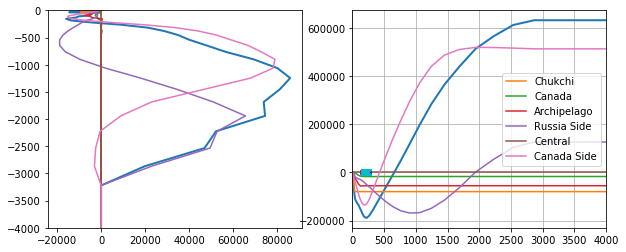

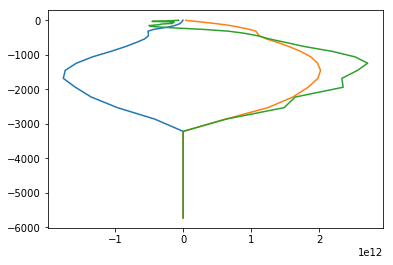

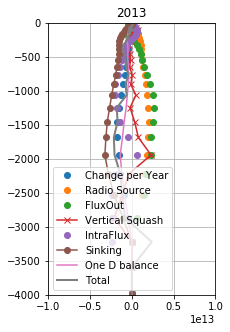

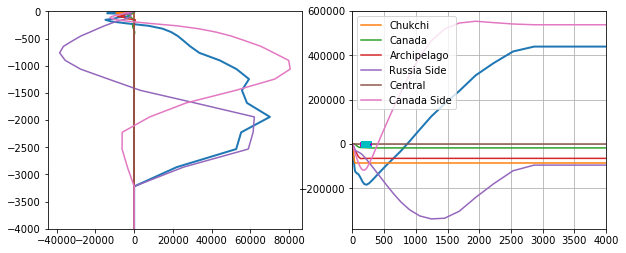

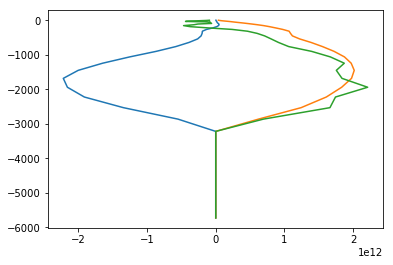

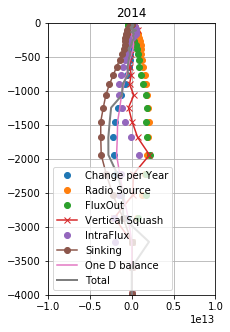

In [158]:
unaccounted = np.zeros((12, 50))
fluxout = np.zeros((12, 50))
intraflux = np.zeros((12, 50))
change = np.zeros((12, 50))
layer_delta_sink = np.zeros((12, 50))
dv = np.zeros((12, 50))
icount = 0
for yearin in range(2003, 2015):
    tr8, tr10, tr12, tt = get_tracer(yearin)
    u_vel = vel('U', yearin)
    v_vel = vel('V', yearin)
    fluxout[icount] = advection(tt, u_vel, v_vel)
    
    xflux, yflux = intra_flux(u_vel, v_vel, tt)
    intraflux[icount] = xflux + yflux
    
    layer_vertical_advection = get_vertical_advection(yearin)
    dv[icount, 0:-1] = (layer_vertical_advection[1:] - layer_vertical_advection[0:-1])
    
    tr8_before, tr10_before, tr12_before, tt_before = get_tracer(yearin - 1)
    tr8_after, tr10_after, tr12_after, tt_after = get_tracer(yearin + 1)
    tbefore_volume = tracer_volume(tt_before)
    tafter_volume = tracer_volume(tt_after)
    change[icount] = (tafter_volume - tbefore_volume)/2.

    fig, ax = plt.subplots(1, 1)
    ax.plot(change[icount], -gdept0)
    ax.plot(radio_source, -gdept0)
    ax.plot(fluxout[icount]*oneyear, -gdept0);

    fac, Ice_from_predifinelastlayer = find_fac(yearin)
    deltasink = find_deltasink(yearin, Ice_from_predifinelastlayer, fac)
    layer_delta_sink[icount] = sum_deltasink(deltasink)

    fig, ax = plt.subplots(1, 1, figsize=(3, 5))
    ax.plot(change[icount], -gdept0, 'o', label='Change per Year')
    ax.plot(radio_source, -gdept0, 'o', label='Radio Source')
    ax.plot(fluxout[icount]*oneyear, -gdept0, 'o', label='FluxOut')
    ax.plot(dv[icount]*oneyear, -gdept0, 'x-', label='Vertical Squash')
    ax.plot(intraflux[icount]*oneyear, -gdept0, 'o', label='IntraFlux')
    ax.plot(layer_delta_sink[icount], -gdept0, 'o-', label='Sinking')
    ax.plot(radio_source+layer_delta_sink[icount], -gdept0, label='One D balance')
    ax.plot(radio_source + layer_delta_sink[icount] - (intraflux[icount] + fluxout[icount])*oneyear
            +dv[icount]*oneyear,
            -gdept0, label="Total", linewidth=2)
    ax.set_ylim(-650, -350)
    ax.set_ylim(-4000, 0)
    ax.set_xlim(-1e13, 1e13)
    ax.legend()
    ax.grid()
    ax.set_title(yearin)
    
    unaccounted[icount, :] = change[icount] - (radio_source + layer_delta_sink[icount] 
                                               - (intraflux[icount] + fluxout[icount])*oneyear
                                              + dv[icount]*oneyear)
    icount += 1


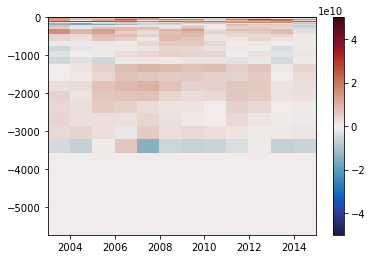

In [159]:
plt.pcolormesh(range(2003, 2016), -gdept0[1:], (unaccounted[0:13, 1:]/e3t0[1:]).transpose(), cmap=cm.balance, vmax= 5e10, vmin=-5e10)
plt.colorbar();

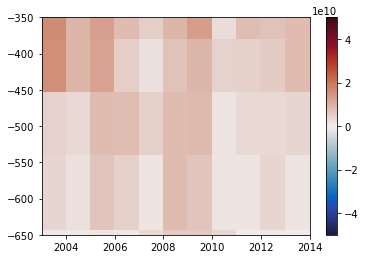

In [160]:
plt.pcolormesh(range(2003, 2015), -gdept0[1:], (unaccounted[:, 1:]/e3t0[1:]).transpose(), cmap=cm.balance, vmax= 5e10, vmin=-5e10)
plt.ylim(-650, -350)
plt.colorbar();


/Users/sallen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/sallen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/sallen/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


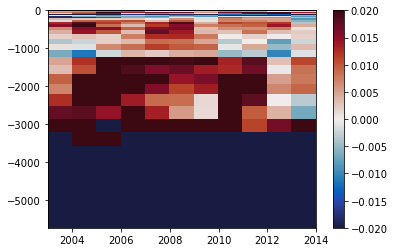

In [161]:
plt.pcolormesh(range(2003, 2015), -gdept0[1:], (unaccounted[1:12, 1:]/layer_volume[1:]).transpose(), 
               cmap=cm.balance, vmax=0.02, vmin=-0.02)
#plt.ylim(-650, -350)
plt.colorbar();

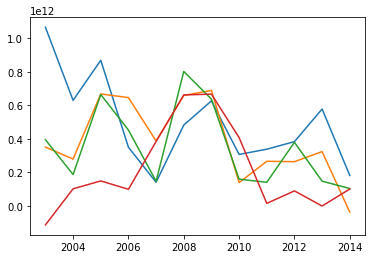

In [162]:
plt.plot(range(2003, 2015), (unaccounted[0:12, 29:33]))

[ 453.93774517  541.08890874]


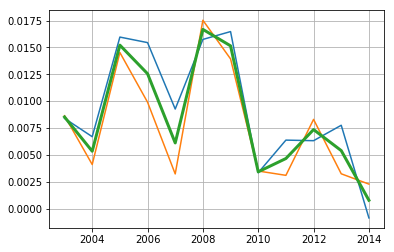

In [163]:
i1, i2 = 30, 31+1
plt.plot(range(2003, 2015), (unaccounted[0:12, i1:i2]/layer_volume[i1:i2]))
plt.plot(range(2003, 2015), (unaccounted[0:12, i1:i2].sum(axis=1)/layer_volume[i1:i2].sum()), 
        linewidth=3)
plt.grid()
print (gdept0[i1:i2])

Unaccounted 4.63800480094
Change -6.6795005747
intraflux -7.29599048532
dv -2.0820776914
fluxout 11.0757700494
sink -18.8558642426
radio 13.4002161224


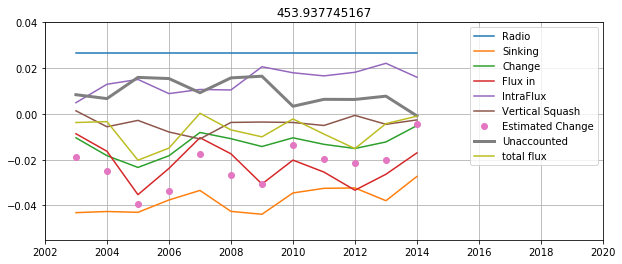

In [169]:
layer = 30
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(range(2003, 2015), np.ones(12)*radio_source[layer]/layer_volume[layer], label ='Radio')
ax.plot(range(2003, 2015), (layer_delta_sink[0:12, layer]/layer_volume[layer]), label = 'Sinking')
ax.plot(range(2003, 2015), (change[0:12, layer]/layer_volume[layer]), label='Change')
ax.plot(range(2003, 2015), (-fluxout[0:12, layer]*oneyear/layer_volume[layer]), label='Flux in')
ax.plot(range(2003, 2015), (-intraflux[0:12, layer]*oneyear/layer_volume[layer]), label='IntraFlux')
plt.plot(range(2003, 2015), (dv[0:12, layer]*oneyear/layer_volume[layer]), label='Vertical Squash')
ax.plot(range(2003, 2015), (np.ones(12)*radio_source[layer] + layer_delta_sink[0:12, layer]
                            -(fluxout[0:12, layer]+intraflux[0:12, layer])*oneyear
                           + dv[0:12, layer]*oneyear)
            /layer_volume[layer], 'o', label='Estimated Change')
ax.plot(range(2003, 2015), (unaccounted[0:12, layer]/layer_volume[layer]), label='Unaccounted',
        linewidth=3)
ax.plot(range(2003, 2015), (-fluxout[0:12, layer]*oneyear/layer_volume[layer] -
                           intraflux[0:12, layer]*oneyear/layer_volume[layer]), label='total flux')
ax.grid()
ax.legend()
ax.set_xlim(2002, 2020)
ax.set_ylim(-0.055, 0.04)
ax.set_title(gdept0[layer])
print ('Unaccounted', unaccounted[0:12, layer].sum()/1e12)
print ('Change', change[0:12, layer].sum()/1e12)
print ('intraflux', intraflux[0:12, layer].sum()*oneyear/1e12)
print ('dv', dv[0:12, layer].sum()*oneyear/1e12)
print ('fluxout', fluxout[0:12, layer].sum()*oneyear/1e12)
print ('sink', layer_delta_sink[0:12, layer].sum()/1e12)
print ('radio', 12*radio_source[layer]/1e12)

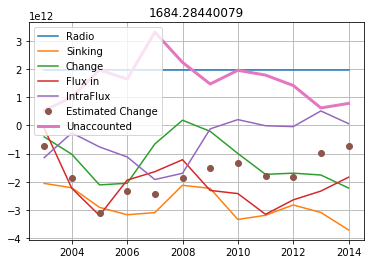

In [135]:
id =38
plt.plot(range(2003, 2015), np.ones(12)*radio_source[id], label ='Radio')
plt.plot(range(2003, 2015), (layer_delta_sink[0:12, id]), label = 'Sinking')
plt.plot(range(2003, 2015), (change[0:12, id]), label='Change')
plt.plot(range(2003, 2015), (-fluxout[0:12, id]*oneyear), label='Flux in')
plt.plot(range(2003, 2015), (-intraflux[0:12, id]*oneyear), label='IntraFlux')
plt.plot(range(2003, 2015), (np.ones(12)*radio_source[id] + layer_delta_sink[0:12, 31]
                            -(fluxout[0:12, id]+intraflux[0:12, id])*oneyear
                            +dv[0:12, id]*oneyear), 
         'o', label='Estimated Change')
plt.plot(range(2003, 2015), (unaccounted[0:12, id]), label='Unaccounted', linewidth=3)
plt.grid()
plt.title(gdept0[id])
plt.legend(loc='upper left');

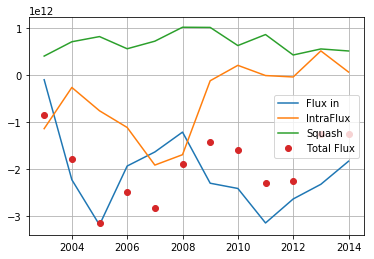

In [136]:
plt.plot(range(2003, 2015), (-fluxout[0:12, 38]*oneyear), label='Flux in')
plt.plot(range(2003, 2015), (-intraflux[0:12, 38]*oneyear), label='IntraFlux')
plt.plot(range(2003, 2015), dv[0:12, 38]*oneyear, label="Squash")
plt.plot(range(2003, 2015), ( -(fluxout[0:12, 38]+intraflux[0:12, 38])*oneyear
                            +dv[0:12, 38]*oneyear),
         'o', label='Total Flux')
plt.grid()
plt.legend();

380.213021112 1452.25093765 1684.28440079 2225.07793765


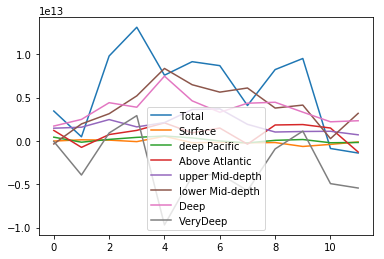

In [137]:
plt.plot(np.sum(unaccounted[:, 1:], axis=1), label='Total');
plt.plot(np.sum(unaccounted[:, 1:10], axis=1), label='Surface');
plt.plot(np.sum(unaccounted[:, 10:20], axis=1), label='deep Pacific');
plt.plot(np.sum(unaccounted[:, 10:29], axis=1), label='Above Atlantic');
plt.plot(np.sum(unaccounted[:, 29:34], axis=1), label='upper Mid-depth');
plt.plot(np.sum(unaccounted[:, 34:39], axis=1), label='lower Mid-depth');
plt.plot(np.sum(unaccounted[:, 38:40], axis=1), label='Deep');
plt.plot(np.sum(unaccounted[:, 40:50], axis=1), label='VeryDeep');
print (gdept0[29], gdept0[37], gdept0[38], gdept0[40])
plt.legend();

/Users/sallen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


(-100, 100)

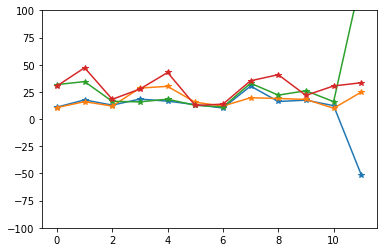

In [138]:
timescale = np.zeros((12, 50))
icount = 0
for yearin in range(2003, 2015):
    tr8, tr10, tr12, tt  = get_tracer(yearin)
    tvolume = tracer_volume(tt)
    timescale[icount] = tvolume/unaccounted[icount]
    icount += 1
plt.plot(timescale[:, 28:32], '*-');
plt.ylim((-100, 100))

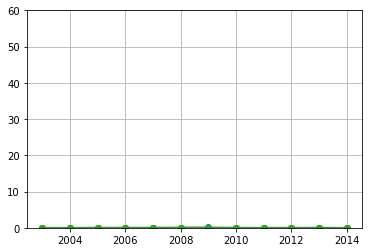

In [139]:
error = 0.016
plt.plot(range(2003, 2015), 1./(error + abs(timescale[:, 30:33])),'o-')
plt.ylim(0, 60)
plt.grid();

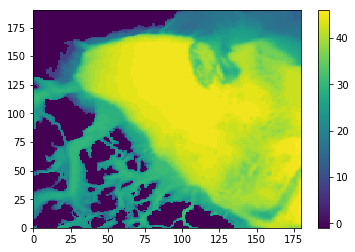

In [140]:
plt.pcolormesh(mbathy[imin:imax, jmin:jmax])
plt.colorbar();

In [141]:
print (gdept0[29:33])

[ 380.21302111  453.93774517  541.08890874  643.56684341]


In [142]:
print (gdepw0[43])

3040.51536164


In [143]:
print (bathy[imin+161, jmin+100], mbathy[imin+161, jmin+100])
print (bathy[imin+162, jmin+100], mbathy[imin+162, jmin+100])

3275.02 44
2982.36 43


So mbathy >= 44 is depth > 3000